In [1]:
import sys
import numpy as np
import matplotlib.cm  as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, MeanShift, AgglomerativeClustering, KMeans

sys.path.append('..')
from utils import data_preprocesados, etiquetas, LP_datos, plot_LP_list

La idea de este cuaderno es probar diferentes algoritmos de clustering y ver si somos capaces de separar las señales en varias clases, y comparar las señales de un mismo cluster entre sí. Esto nos va a permitir validad "a ojo" estos modelos y buscar etiquetas manualmente.

## 1. DBSCAN

Buscando el mejor modelo

In [5]:
X_all = data_preprocesados(2, n_components=5)

[0.35839694 0.2125936  0.08712974 0.06979471 0.06568434] 0.7935993420974994


In [10]:
outs = []
for s in [1,5,10]:
    eps = []
    scores = []
    for e in np.arange(5,6.6,0.2):
        dbscan = DBSCAN(eps=e, min_samples=s)
        dbscan.fit(X_all)
        if len(Counter(dbscan.labels_)) > 1:
            score = silhouette_score(X_all, dbscan.labels_)
        else:
            score = -1
        eps.append(e)
        scores.append(score)
    outs.append((eps, scores, s))

In [12]:
max_score = -1
for out in outs:
    score = max(out[1])
    eps = out[0][np.argmax(out[1])]
    min_sample = out[2]

    if score > max_score:
            max_score = score
            best_eps = eps
            best_min_sample = min_sample

print(f'Best performance:: Score: {max_score:.2f} eps: {best_eps:.1f} min_sample: {best_min_sample}')

Best performance:: Score: 0.75 eps: 6.2 min_sample: 5


In [17]:
eps = 6.2
min_samples = 5
dbest = DBSCAN(eps=eps, min_samples=min_samples)
dbest.fit(X_all)

print('Etiquetas:', Counter(dbest.labels_))

Etiquetas: Counter({0: 1040, -1: 4})


El mejor modelo me da 1 etiqueta para representar 1040 señales y 4 mal clasificadas

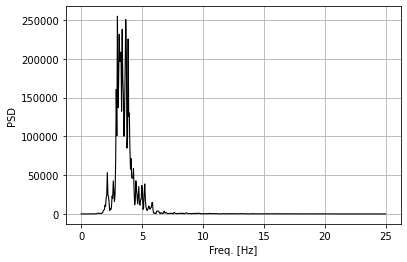

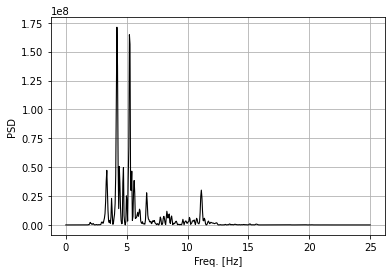

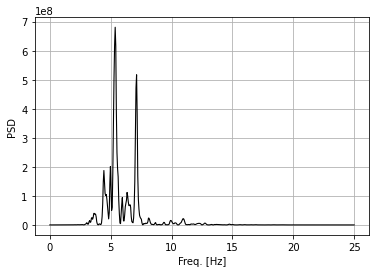

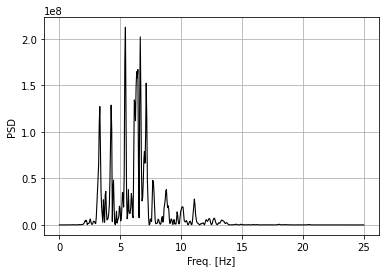

In [22]:
gen = LP_datos()
for n in np.where(dbest.labels_<0)[0]:
    gen[n].plot()


No pareciera que estas señales tengan mucho que ver...

## 2.MeanShift

In [26]:
ms = MeanShift(cluster_all=False).fit(X_all)
print('Num. labels:', len(Counter(ms.labels_)))
print('Score:', silhouette_score(X_all, ms.labels_))
print(Counter(ms.labels_))

Num. labels: 10
Score: 0.24235183703396654
Counter({0: 654, -1: 382, 7: 1, 8: 1, 1: 1, 4: 1, 5: 1, 3: 1, 2: 1, 6: 1})


EL  score es muy bajo, y las agrupaciones son de a un evento. Por tanto, no me sirve

## 3.Hierarchical

In [84]:
print(' linkage ', 'n_cluster', 'score')
for n in (2,3,4,5,6):
    for linkage in ['ward']:
        ms = AgglomerativeClustering(n_clusters=n, linkage=linkage).fit(X_all)
        print(f'{linkage:<8}', f'{n:^9}', f'{silhouette_score(X_all, ms.labels_):^5.2f}')


 linkage  n_cluster score
ward         2     0.24 
ward         3     0.26 
ward         4     0.26 
ward         5     0.25 
ward         6     0.25 


Counter({1: 397, 0: 339, 2: 226, 4: 81, 3: 1})


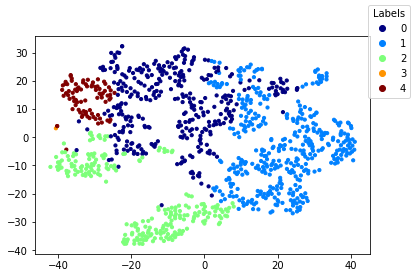

In [131]:
# representar los clusters
n = 5
best_ms = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward').fit(X_all)

colors = best_ms.labels_
print(Counter(colors))

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_all)
norm = mcolors.Normalize(0, n-1)

fig, ax = plt.subplots(1,1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=colors, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')

Comparemos algunos LPs para algunos labels

In [104]:
gen = LP_datos()
labels = best_ms.labels_
n_lps = 3
la = 4
lb = 1

/home/ifm/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


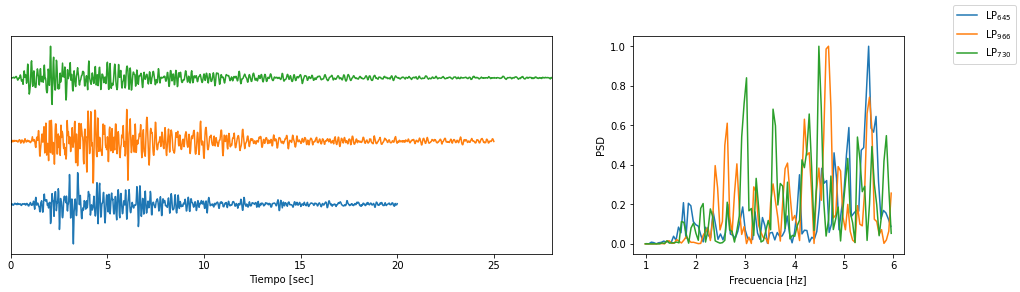

In [113]:
# la
idx_a = np.where(labels==la)[0]
LP_idxs_a = idx_a[np.random.choice(idx_a.shape[0], n_lps)]
plot_LP_list(map(gen.get, LP_idxs_a))

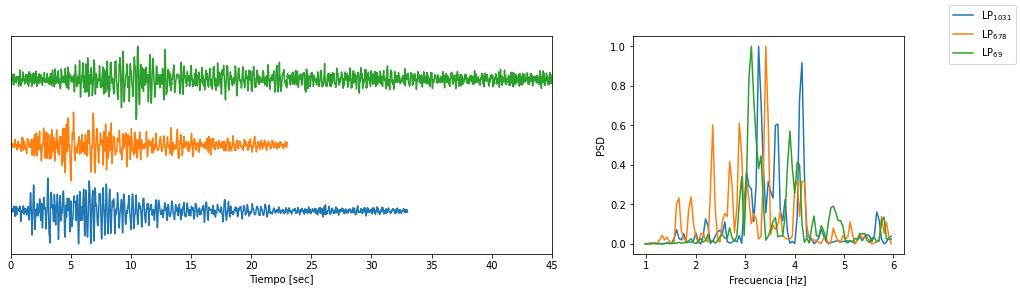

In [109]:
# lb
idx_b = np.where(labels==lb)[0]
LP_idxs_b = idx_b[np.random.choice(idx_b.shape[0], n_lps)]
plot_LP_list(map(gen.get, LP_idxs_b))

## 4.KMeans

In [116]:
for n_clusters in [2, 3, 4, 5, 6]:
    km = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = km.fit_predict(X_all)
    silhouette_avg = silhouette_score(X_all, cluster_labels)
    print(f'{n_clusters:>6}', f'{silhouette_avg:>10.2f}')
print('')

     2       0.32
     3       0.33
     4       0.28
     5       0.28
     6       0.23



Counter({3: 418, 2: 277, 1: 213, 0: 136})


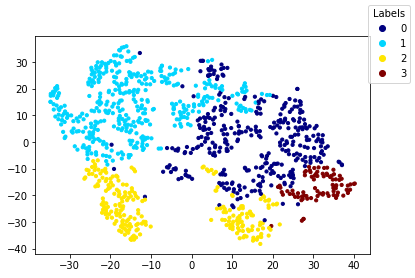

In [132]:
n=4
km_best = KMeans(n_clusters=n, random_state=0).fit_predict(X_all)
labels = list(km_best)
print(Counter(labels))

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_all)
norm = mcolors.Normalize(0, n-1)

fig, ax = plt.subplots(1,1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=colors, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')


Veamos algunas parejas

In [138]:
gen = LP_datos()
labels = best_ms.labels_
n_lps = 3
la = 2
lb = 1

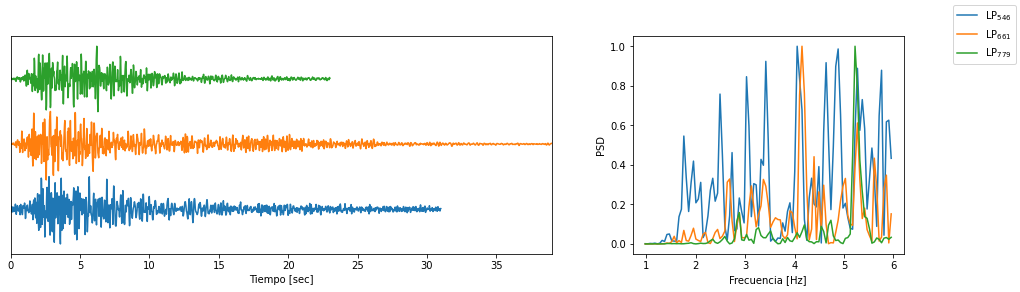

In [139]:
# la
idx_a = np.where(labels==la)[0]
LP_idxs_a = idx_a[np.random.choice(idx_a.shape[0], n_lps)]
plot_LP_list(map(gen.get, LP_idxs_a))

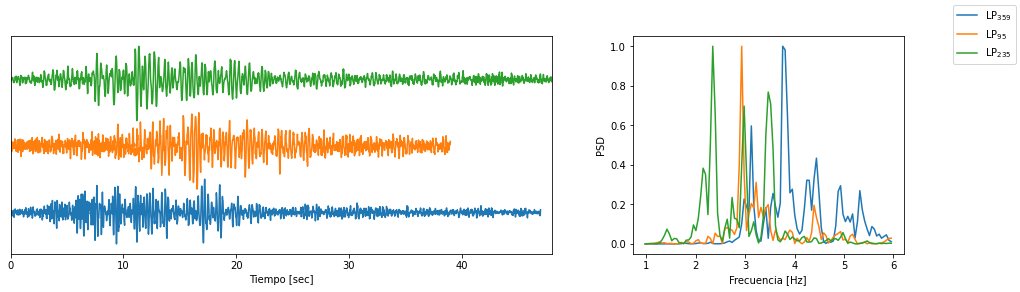

In [140]:
# lb
idx_b = np.where(labels==lb)[0]
LP_idxs_b = idx_b[np.random.choice(idx_b.shape[0], n_lps)]
plot_LP_list(map(gen.get, LP_idxs_b))

## Conclusion

Hasta aquí hemos revisado los algorítmos de clustering. Concluimos que el dataset es separable en al menos, 4 o 5 clases. Sin embargo no todos los LPs de cada cluster son similares y dada la gran cantidad de señales que constitute cada cluster, cuesta mucho esfuerzo poder diferenciar visualmente entre clases.
Es por ello que decidimos enfocarnos en explotar los algortimos de Mixtura para seleccionar aquellas señales que tienen una probabilidad de pertenencia a clase mayor.